In [59]:
#import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler 
import model 

import numpy as np
from simtk import openmm, unit

from pydiffmap import diffusion_map as dmpy
import helpers
import model

from simtk.openmm import app

In [60]:
import seaborn as sns

sns.set_style("white")
sns.set()
sns.axes_style("white",{'axes.grid': False})

current_palette = sns.diverging_palette(220, 20, n=7)
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["denim blue"]
green = sns.xkcd_rgb["medium green"]

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
    

In [61]:
#diffmapmethod='T300/DiffMap/'
methodName='std'
methodNameFolder=methodName

#######################
# target temperature
T=300.0

metric_choice = 'euclidean'
  
dataName='Data/'
folderName='/Users/zofia/github/DFM/'
modelName='Chignolin'

inputPDBFile = '/Users/zofia/github/DFM/Chignolin_input/protein.pdb'
pdb = app.PDBFile(inputPDBFile)

protein_topology = pdb.topology

dataFolderName = folderName+dataName+modelName+'/'+methodNameFolder

figuresFolder='Figures'

newpath = os.path.join(os.getcwd(),figuresFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

print(dataFolderName)

mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())

temperature =  T * unit.kelvin#300 * unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=1.0 / unit.picosecond, temperature=temperature, dt=2.0 * unit.femtosecond)

sampler_parameters = {'proteinPDBFile':inputPDBFile, 'proteinEndIndex': 138}
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, params = sampler_parameters, dataFileName='Data')

cv1name = 'd(Asp3N, Gly7O)'
cv2name = 'd(Asp3N, Thr8O)'


/Users/zofia/github/DFM/Data/Chignolin/std
[[ -5.361   5.656   1.824]
 [ -4.575   5.099   2.212]
 [ -6.263   5.293   2.198]
 ..., 
 [-12.179 -10.292 -10.063]
 [-11.387 -10.787 -10.271]
 [-11.886  -9.613  -9.456]] A
Periodic box not adjusted manually.
The position unit is Unit({BaseUnit(base_dim=BaseDimension("length"), name="angstrom", symbol="A"): 1.0})
angstrom
System has 5897 particle(s)
602.266155086 K
Saving Protein Only in shape : (1, 138, 3)


In [62]:
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

def plot_map(Y,  tickspacing1=1.0, tickspacing2=1.0, timestep=1.0, timeunit='ns'):
    if not isinstance(Y, np.ndarray):
        Y = Y[0]
        
    nrbins = 100
    
    sx = 1
    sy = 1
    
    Y1 = sx*Y[:, 0]
    min1 = np.min(Y1)
    max1 = np.max(Y1)
    
    Y2 = sy*Y[:, 1]
    min2 = np.min(Y2)
    max2 = np.max(Y2)
    
    # figure
    plt.figure(figsize=(16,4))
    
    # trajectories
    plt.subplot2grid((2,2), (0,0))
    plt.plot(timestep*np.arange(len(Y1)), Y1)
    plt.xlim(0, timestep*len(Y1))
    plt.yticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    plt.ylabel(cv1name)
    
    plt.subplot2grid((2,2), (1,0))
    plt.plot(timestep*np.arange(len(Y2)), Y2)
    plt.xlim(0, timestep*len(Y2))
    plt.ylabel(cv2name)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    plt.xlabel('time / ' + timeunit)
    
    # histogram data
    plt.subplot2grid((2,2), (0,1), rowspan=2)
    z,x,y = np.histogram2d(Y1, Y2, bins=nrbins)
    z += 0.01
    # compute free energies
    F = -np.log(z)
    
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    plt.contourf(F.T, 100, cmap="Spectral", extent=extent)
    plt.xlabel(cv1name)
    plt.ylabel(cv2name)
    
    xc = 0.5*(x[1:]+x[:-1])
    yc = 0.5*(y[1:]+y[:-1])
    
    # histogram data
    vals, x = np.histogram(Y1, bins=nrbins)
    vals=vals.astype(float)
    vals+= 0.01
    # compute free energies
    F = -np.log(vals)
    xc = 0.5*(x[1:]+x[:-1])
    
    # histogram data
    vals, x = np.histogram(Y2, bins=nrbins)
    vals=vals.astype(float)
    vals+= 0.01
    # compute free energies
    F2 = -np.log(vals)
    xc2 = 0.5*(x[1:]+x[:-1])
    
    plt.figure(figsize=(10,5))
    plt.plot(xc, F)
    plt.plot(xc2, F2)
    plt.legend((cv1name,cv2name))
    plt.ylabel('Free energy')
    plt.show()


    

Populating the interactive namespace from numpy and matplotlib


Loaded trajectory of shape (50000, 138, 3)
No distances smaller than 4


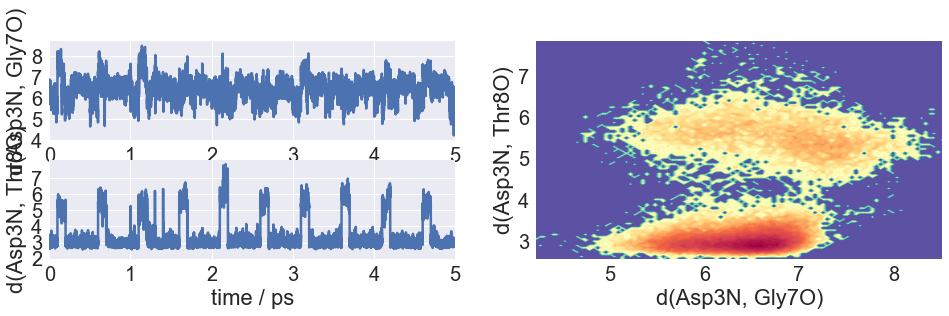

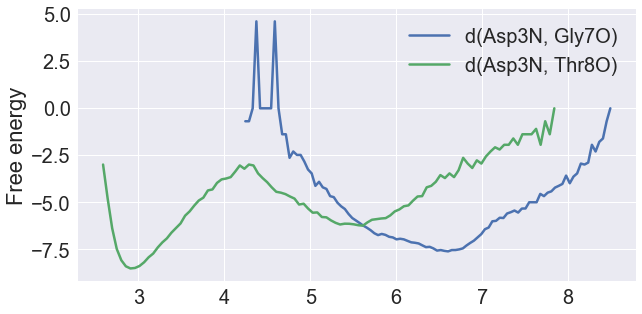

In [63]:
import pyemma
import pyemma.coordinates as coor

import pyemma.plots as mplt
# Switch progress bars off, because this notebook would generate a lot of progress bars
pyemma.config.show_progress_bars = 'True'

feat = coor.featurizer(inputPDBFile)
feat.add_distances([[30, 91], [30,105]], periodic = True)
#print(feat.dimension())

nameData = '/Users/zofia/github/DFM/Data/Chignolin/std/Traj/Chignolintraj_*.h5'
X_FT = helpers.loadData(nameData, protein_topology, 1)

print("Loaded trajectory of shape "+repr(X_FT.shape))

xmd = md.Trajectory(X_FT, protein_topology)
#tica_Cadist, tica_Y_Cadist, tica_cl_Cadist = project_and_cluster(trajs, feat_Cadist)
cv = feat.transform(xmd)


idxsm4 = np.where(cv[:,0] < 4)
there_are_dist_smaller_than_4= True
#print np.array(idxsm4[0]).size == 0:
if np.array(idxsm4[0]).size == 0:
    print("No distances smaller than 4")
    there_are_dist_smaller_than_4=False
    cvSmallerThan4 = cv
else:
    cvSmallerThan4 =  cv[idxsm4,:]

if there_are_dist_smaller_than_4:
    plot_map(cvSmallerThan4, tickspacing1=1.0, tickspacing2=1.0, timestep=0.0001, timeunit='ps')
    gcf().suptitle('Chignolin $D_1<4$', fontsize=20)

idxbg4 = np.where(cv[:,0] >= 4)
cvBiggerThan4 =  cv[idxbg4]

plot_map(cvBiggerThan4, tickspacing1=1.0, tickspacing2=1.0, timestep=0.0001, timeunit='ps')
#gcf().suptitle('Chignolin $D_1\geq 4$', fontsize=20)

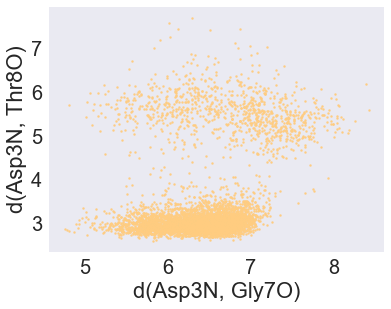

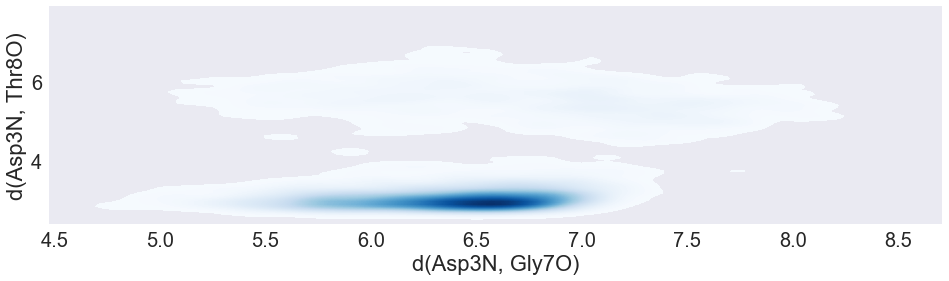

In [35]:
modnr=1

def plotSampling(angles):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    ax.scatter(angles[:, 0], angles[:, 1], s=4, c=[1,0.8,0.5]);
    
    ax.set_xlabel(cv1name)
    ax.set_ylabel(cv2name)
    plt.show()

def plotDensity(angles):
    
    nrLev = 200
    
    xphi = angles[:,0]
    xpsi = angles[:,1]

    ax = sns.kdeplot(xphi, xpsi, shade=True,  n_levels=nrLev, shade_lowest=False, cmap = "Blues")
    ax.set_xlabel(cv1name)
    ax.set_ylabel(cv2name)
    plt.show()


plotSampling(cv[::10])
plotDensity(cv[::10])

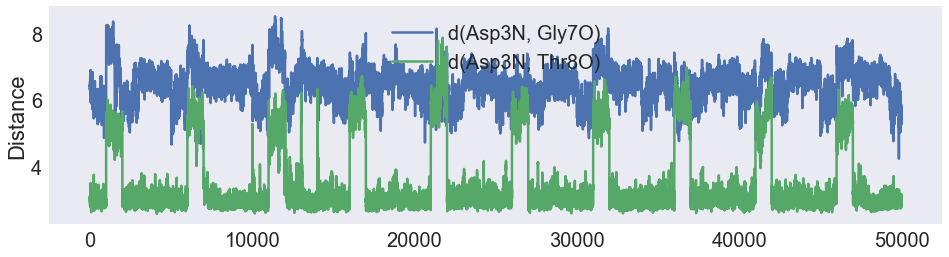

In [36]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = False

r = cvBiggerThan4

plt.figure(figsize(16,4))
plt.plot(range(len(r)), r, '-')
plt.ylabel('Distance')
plt.legend([cv1name, cv2name])
plt.savefig(figuresFolder+'/colvar.png')

plt.show()

In [37]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

pdfFile = '/Users/zofia/github/DFM/interactivePython/Chignolin_postprocessing/Chignolin_input/protein.pdb'

trj = mda.Universe(pdfFile, X_FT) 
print(trj.trajectory)
ref = mda.Universe(pdfFile)
alignment = align.AlignTraj(trj, trj)
alignment.run()
X_aligned = np.zeros(X_FT.shape)
ci=0
for ts in trj.trajectory:
    X_aligned[ci] = trj.trajectory.ts.positions
    ci=ci+1

print(X_aligned.shape)
print(alignment)
X_FT=X_aligned

<MemoryReader with 50000 frames of 138 atoms>
(50000, 138, 3)


In [158]:



# def compute_free_energy(cv, weights=None, nrbins=100, err_bar = False):


#     pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
#     bin_widths = bin_edges[1:] - bin_edges[:-1]
#     bin_centers = bin_edges[:-1] + 0.5*bin_widths
#     free_energy= - np.log(pi_marginal)
    
    
#     if err_bar == True:
        
#         dat, bin_edges = pi_marginal, bin_edges#np.histogram(cv, bins = nrbins, weights = weights)
#         yerrs = np.sqrt(dat)

#         nevents = float(sum(dat))
#         binwidth = (bin_edges[1]-bin_edges[0])
#         dat = dat/nevents/binwidth
#         yerrs = yerrs/nevents/binwidth
        
#         #yerrs = -np.log(yerrs)

       
#         xerrs = bin_centers
        
#         return free_energy, bin_centers, xerrs, yerrs 
#     else:

#         return free_energy, bin_centers
   

In [15]:
# def align_with_mdanalysis(X_FT, smpl):

#     trj = mda.Universe(smpl.model.modelName+'.pdb', X_FT)
#     ref = mda.Universe(smpl.model.modelName+'.pdb')
#     # trj = mda.Universe('/Users/zofia/github/DFM/alanine.xyz', X_FT)
#     # print(trj.trajectory)
#     # ref = mda.Universe('/Users/zofia/github/DFM/alanine.xyz')#, X_FT[0,:,:])


#     alignment = align.AlignTraj(trj, ref)#, filename='rmsfit.dcd')
#     alignment.run()
#     X_aligned = np.zeros(X_FT.shape)
#     ci=0
#     for ts in trj.trajectory:
#         X_aligned[ci] = trj.trajectory.ts.positions
#         ci=ci+1

#     #X_aligned = (trj.trajectory.positions)
#     #print(X_aligned.shape)
#     #print(alignment)
#     return X_aligned

# def rmsd_align(XL):
    
#     xx=[]
#     for i in range(len(XL)):
#         xx.append(XL[i].value_in_unit(smpl.model.x_unit))
        
#     xx=np.asarray(xx)
#     #print(xx.shape)
    
#     xx = align_with_mdanalysis(xx, smpl)
    
#     XL=[]
#     for i in range(xx.shape[0]):
#         XL.append(unit.Quantity(xx[i], smpl.model.x_unit))
#     return XL
    
# #XL = rmsd_align(XL)

# Compute first DCs to chose initial conditions

In [64]:
E = list()
for i in range(10):
    energyFile = '/Users/zofia/github/DFM/Data/Chignolin/std/Traj/Energies/E_'+repr(i)+'.npy'
    E.append( np.load(energyFile))
    
E = np.asarray(E)
E = E.reshape(E.shape[0]*E.shape[1])
print(E.shape)
print(X_FT.shape)
#print(cvBiggerThan4.shape)
#print(smpl.model.energy_unit)

#X_FT=X_FT_orig
#cv=cv_orig

X_FT_orig = X_FT
cv_orig = cv
E_orig = E
#E=E[::100]
#X_FT = X_FT[::100]
#E = E[::10]
#cv = cv[::100]

(50000,)
(50000, 138, 3)


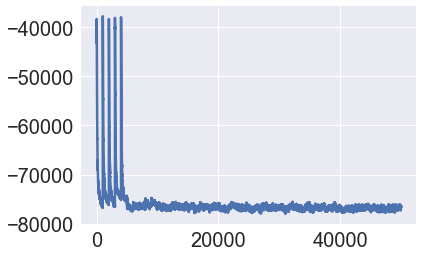

1007


In [73]:
plt.plot(range(len(E)), E)
plt.show()

print(np.argmax(E))

## visualize the frame at this index - 

In [39]:
X_FT=X_FT_orig[::100]
cv=cv_orig[::100]
E=E_orig[::100]

In [40]:
print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

#E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
#qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


# fig = plt.figure(figsize=(16,6))
# ax = fig.add_subplot(121)
# cax = ax.hist(E, 1000, normed=True)
# ax.set_title('Histogram Energy')


# ax2 = fig.add_subplot(122)
# cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
# ax2.set_xlabel(cv_name)
# ax2.set_ylabel('Energy')
# ax2.set_title('Potential Energy')

# #fig.savefig(simulationFolder+'/energy.png')

# plt.show()

Get the target density at sampled data points
... might take a while ...
Done


/Users/zofia/github/DFM/srcDiffmap/helpers.py:63: RuntimeWarning: overflow encountered in exp
  qTargetDistribution[i]=np.exp(-(betatimesH_unitless))


In [41]:
print(cv.shape)
print(E.shape)
print(X_FT.shape)
print(5000*22)
print(5000*138)

(500, 2)
(500,)
(500, 138, 3)
110000
690000


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


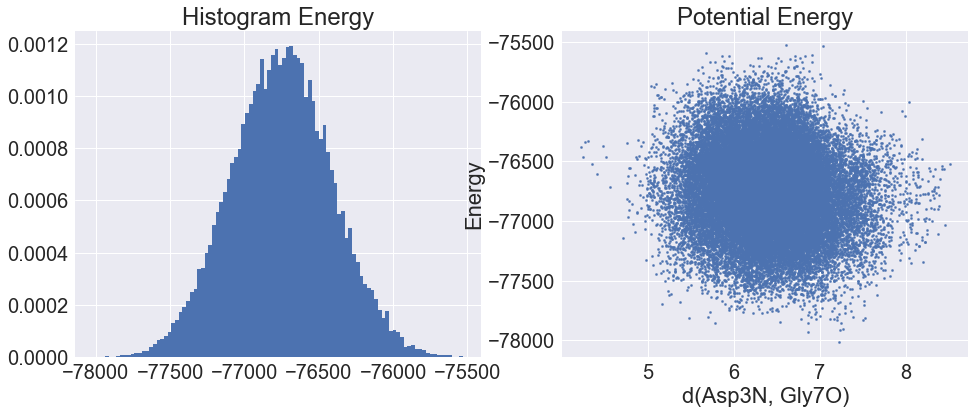

In [76]:
#print(E)
shift = 10000
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E[shift:], 100, normed=True)
ax.set_title('Histogram Energy')

ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(cv[shift:,0], E[shift:] ,s=5 )
ax2.set_xlabel(cv1name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

#fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [56]:
import pydiffmap as mdpy

################ diffusion diffmaps
vanilla=True
nrEvecs = 2

epsilon='bgh'
nrNeighbors=1000

compute_spectral_decomposition = 1

if nrNeighbors>=X_FT.shape[0]:
        nrNeighbors=int(0.9*X_FT.shape[0])

Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

    
# if compute_spectral_decomposition==0:
#         my_kernel = dmpy.kernel.Kernel(kernel_type='gaussian', k=nrNeighbors,
#                                   epsilon=epsilon,
#                                   metric='euclidean')
#         my_kernel.fit(Xresh)
        
#         K=my_kernel.compute(Xresh)
#         q = np.array(K.sum(axis=1)).ravel()
# else:
if vanilla:
    mydmap = dmpy.DiffusionMap(alpha = 0.5, n_evecs = nrEvecs, epsilon = epsilon,  k=nrNeighbors, metric='euclidean')#, neighbor_params = {'n_jobs':-4})    
    dmap = mydmap.fit_transform(Xresh)#, weights = qTargetDistribution)
else:     
    mydmap = dmpy.DiffusionMap(alpha = 1, n_evecs = nrEvecs, epsilon = epsilon,  k=nrNeighbors, metric='euclidean')#, neighbor_params = {'n_jobs':-4})    
    dmap = mydmap.fit_transform(Xresh, weights = qTargetDistribution)

print('pydiffmap done')
# P = mydmap.P
evals = mydmap.evals
evecs = mydmap.evecs

# [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
# phi = np.real(evecsT.ravel())

q = mydmap.q

pydiffmap done


In [57]:
#mycmap = sns.diverging_palette(220, 20, n=7,as_cmap=True)
#mycmap = sns.cubehelix_palette(light=1, as_cmap=True)
mycmap = cm.coolwarm#"RdBu_r"
sns.set_style("dark")

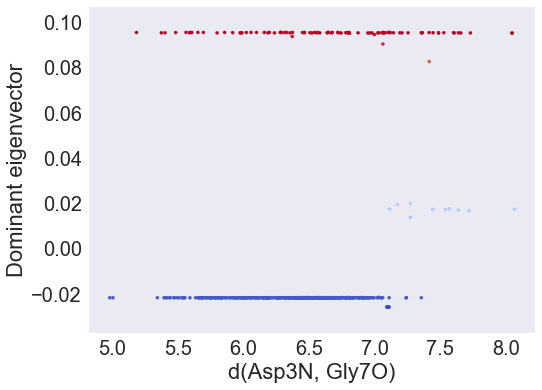

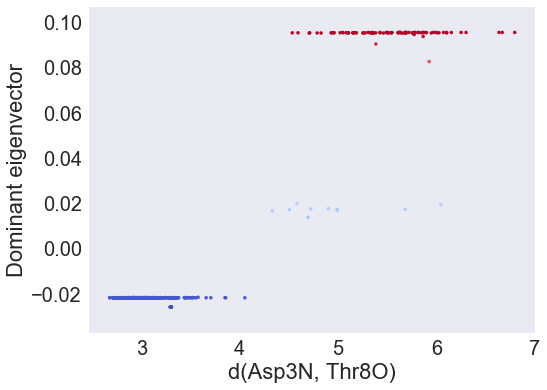

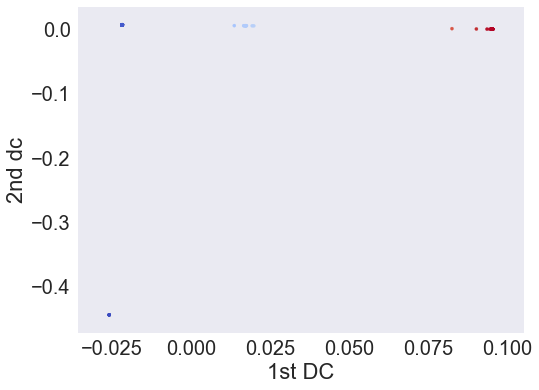

In [58]:
import matplotlib.cm as cm

if compute_spectral_decomposition==1:
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(cv[:,0], evecs[:,0], s=10, c=evecs[:,0], cmap = mycmap)#range(len(X_FT)), cmap = "Blues")
    plt.xlabel(cv1name)
    plt.ylabel('Dominant eigenvector')
    
#    plt.savefig(figuresFolder+'/dc1_phi.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(cv[:,1], evecs[:,0], s=10, c=evecs[:,0], cmap = mycmap)
    plt.xlabel(cv2name)
    plt.ylabel('Dominant eigenvector')
    
#    plt.savefig(figuresFolder+'/dc2_phi.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
    
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(evecs[:,0], evecs[:,1], s=10, c=evecs[:,0], cmap = mycmap)
    plt.xlabel('1st DC')
    plt.ylabel('2nd dc')
    plt.savefig(figuresFolder+'/dc1_dc2.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()


    

In [33]:
# savingfolder = 'LangevinUnbiasFigures/Alanine/nrpoints_'+repr(nrInitialPoints)#+'_T_'+repr(smpl.integrator.temperature.value_in_unit(unit.kelvin))
# newpath = os.path.join(os.getcwd(),savingfolder)
# if not os.path.exists(newpath):
#         os.makedirs(newpath)

In [ ]:
# # check visually random choice of initial points

# initial_conditions_random=X_FT[np.random.randint(len(X_FT),size = nrInitialPoints)]

# cv_phi=compute_dihedrals_phi(X_FT)
# cv_psi=compute_dihedrals_psi(X_FT)

# cv_phi_IC_rand=compute_dihedrals_phi(initial_conditions_random)
# cv_psi_IC_rand=compute_dihedrals_psi(initial_conditions_random)


# fig = plt.figure(figsize=(10,6))
# x1=plt.scatter(cv_phi, cv_psi, c=evecs[:,0], s=5, cmap=mycmap)
# cbar=plt.colorbar(x1)

# #plt.scatter(cv_phi_IC, cv_psi_IC, c='r', s=20)
# plt.scatter(cv_phi_IC_rand, cv_psi_IC_rand, c='b', s=50)

   
# #plt.title('Free energy: Alanine dipeptide ')
# plt.xlabel(r'$\Phi$ Angle [radians]')
# plt.xlim(-np.pi, np.pi)
# plt.ylabel(r'$\Psi$ Angle [radians]')
# plt.ylim(-np.pi, np.pi)
# plt.title('1st DC')

# plt.savefig(savingfolder+'/random_init_cond_alanine.png',  format='png', dpi=100, bbox_inches='tight')
# plt.show()

# To be modified from this point: Iterate Langevin to unbias

In [22]:
# def Langevin_step(x , v, f,a, b,  dt):
    
#     v = v + ((0.5*dt ) * f/ smpl.model.masses)
#     x = x + ((0.5*dt ) * v)


#     v = (a * v) + b * np.random.randn(*x.shape) * np.sqrt(smpl.kT / smpl.model.masses)

#     x = x + ((0.5*dt ) * v)
#     f=smpl.model.force(x)

#     v = v + ((0.5*dt ) * f / smpl.model.masses)
    
#     return x, v , f

In [23]:
# # increase temperature

# T_increased = 800
# temperature =  T_increased * unit.kelvin

# gamma = 1.0 / unit.picosecond
# dt = 1.0 * unit.femtosecond

# temperatureAlpha= 0.0* unit.kelvin

# # simulation class sampler takes integrator class with chosen parameters as input
# intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
# smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')


# T = 300
# temperature =  T * unit.kelvin

# # simulation class sampler takes integrator class with chosen parameters as input
# intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
# smpl_target=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')




In [24]:
# savingfolder_results = 'LangevinUnbiasFigures/Alanine/nrpoints_'+repr(nrInitialPoints)+'/T_'+repr(smpl.integrator.temperature.value_in_unit(unit.kelvin))
# newpath = os.path.join(os.getcwd(),savingfolder_results)
# if not os.path.exists(newpath):
#         os.makedirs(newpath)

In [25]:
# numberOfLangevinSteps = 10000

# X_short = np.copy(initial_conditions)
# XL = []
# [XL.append( X_short[n] * smpl.model.x_unit) for n in range(X_short.shape[0])]

# kT = smpl.kT
# mass = smpl.model.masses 

# q = np.copy(X_short)

# plotSamplingDihedrals_fromData(q, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Initial condition')

  

# a = np.exp(-smpl.integrator.gamma * (smpl.integrator.dt))
# b = np.sqrt(1 - np.exp(-2 * smpl.integrator.gamma * (smpl.integrator.dt)))

# X_result = list()

# if numberOfLangevinSteps < 1000:
#     numberOfLangevinSteps += 1000
    
# for n in range(len(XL)):
        
#     fLan = smpl.model.force(XL[n])
#     v = np.random.randn(*XL[n].shape) * np.sqrt(smpl.kT / smpl.model.masses)
#     for i in range(numberOfLangevinSteps):
#             XL[n], v, fLan = Langevin_step(XL[n] , v, fLan,a, b,  smpl.integrator.dt)
            
#             #if numberOfLangevinSteps > 1000:
#             if i > 1000:
#                     X_result.append(np.asarray(XL[n]))
#             else:
#                 X_result.append(np.asarray(XL[n]))
#             #q[n,:,:] =  np.copy(XL[n].value_in_unit(smpl.model.x_unit))
#             #X_result.append(q)

# X_result = np.asarray(X_result)
    
# ## plot progress
# plotSamplingDihedrals_fromData(X_result, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Iteration '+repr(n))
# if np.isnan(q).any():
#     print('Explosion at iteration '+repr(ns)+'. Nan.')
    

In [26]:

# plotSamplingDihedrals_fromData(X_short, smpl.model.testsystem.topology, methodName=None, color='b', title='Initial state')
# plotSamplingDihedrals_fromData(X_result, smpl.model.testsystem.topology, methodName=None, color='b', title='After '+repr(X_result.shape[0])+' Langevin steps')


In [27]:
# xphi = compute_dihedrals_phi(X_FT)
# xpsi = compute_dihedrals_psi(X_FT)

# xphires = compute_dihedrals_phi(X_result[::10])
# xpsires = compute_dihedrals_psi(X_result[::10])

In [28]:
# import seaborn as sns



# nrLev = 20

# ax = sns.kdeplot(xphi, xpsi, shade=True,  n_levels=nrLev, shade_lowest=False, cmap = "Blues")
# ax.set_xlabel('$\phi$[radians]')
# ax.set_ylabel('$\psi$[radians]')
# ax.set_xlim([-np.pi, np.pi])
# ax.set_ylim([-np.pi, np.pi])
# plt.show()

# ax = sns.kdeplot(xphires, xpsires, shade=True,  n_levels=nrLev,shade_lowest=False, cmap = "Blues")
# ax.set_xlabel('$\phi$[radians]')
# ax.set_ylabel('$\psi$[radians]')
# ax.set_xlim([-np.pi, np.pi])
# ax.set_ylim([-np.pi, np.pi])
# plt.show()

In [29]:
# #print(len(X_result_all))

# Xr = align_with_mdanalysis(X_result, smpl)


In [30]:


# np.save(savingfolder_results+'/results.npy',X_result)
# np.save(savingfolder_results+'/numberOfSteps.npy',numberOfLangevinSteps)
# np.save(savingfolder_results+'/intialPoints.npy',X_short)


In [31]:
# X_result_all = np.load(savingfolder_results+'/results.npy')
# # X_result = X_result_all[1000:]
# # print(X_result.shape)

In [32]:
# print('Get the target density at sampled data points')
# print('... might take a while ...')

# """
# target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
# """

# E_res = helpers.computeEnergy(Xr, smpl)
# #E_res = helpers.computeEnergy(X_result, smpl)

# qTargetDistribution_higher_temperature= helpers.computeTargetMeasure(Xr, smpl, E_res)
# qTargetDistribution_target= helpers.computeTargetMeasure(Xr, smpl_target, E_res)
# # qTargetDistribution_higher_temperature= helpers.computeTargetMeasure(X_result, smpl, E_res)
# # qTargetDistribution_target= helpers.computeTargetMeasure(X_result, smpl_target, E_res)

# weights =  qTargetDistribution_target / qTargetDistribution_higher_temperature

# # fig = plt.figure(figsize=(16,6))
# # ax = fig.add_subplot(121)
# # cax = ax.hist(E, 1000, normed=True)
# # ax.set_title('Histogram Energy')


# # ax2 = fig.add_subplot(122)
# # cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
# # ax2.set_xlabel(cv_name)
# # ax2.set_ylabel('Energy')
# # ax2.set_title('Potential Energy')

# #fig.savefig(simulationFolder+'/energy.png')

# #plt.show()

# Compare free energies with reference

In [33]:
# # load reference free energy profile at 300 K
# reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

# FE_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE_phi.npy')
# bc_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins_phi.npy')

# FE_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE.npy')
# bc_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins.npy')

In [34]:
# #weights_all = weights
# print(len(weights_all))
# print(len(weights_all))
# #weights=weights_all
# print(smpl.integrator.temperature)
# print(smpl_target.integrator.temperature)

In [ ]:
# import imp
# imp.reload(helpers)

In [ ]:
# plt.scatter(compute_dihedrals_phi(X_result), weights)
# plt.show()

In [35]:
# nrBins=100
# shift=1

# #print('Computing collective variable of trajectory of  '+repr(len(X_short))+' points')
# print('Computing collective variable of trajectory of  '+repr(len(X_result))+' points')
# cv=compute_dihedrals_phi(X_FT)
# cv_langevin=compute_dihedrals_phi(X_result[shift:])
# weights_sh=weights[shift:]


# free_energy_raw_phi, bin_centers_raw_phi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
# free_energy_Langevin_phi, bin_centers_Langevin_phi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)

# cv=compute_dihedrals_psi(X_FT)
# cv_langevin=compute_dihedrals_psi(X_result[shift:])

# free_energy_raw_psi, bin_centers_raw_psi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
# free_energy_Langevin_psi, bin_centers_Langevin_psi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)

# fig = plt.figure(figsize=(20,6))

# ax = fig.add_subplot(121)
# ax.plot(bin_centers_raw_phi, free_energy_raw_phi, '-*b')#s=5, c='b', marker='o')
# #ax.plot(bin_centers_raw_phi, free_energy_raw_phi+ye_raw, ':b')#s=5, c='b', marker='o')
# #ax.plot(bin_centers_raw_phi, free_energy_raw_phi-ye_raw, ':b')#s=5, c='b', marker='o')

# ax.plot(bin_centers_Langevin_phi, free_energy_Langevin_phi,'-*g')# s=5, c='g', marker='o')
# ax.plot(bc_ref_phi, FE_ref_phi,'-*r')# s=5, c='r', marker='o')
# plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
# ax.set_xlabel('Dihedral angle phi')
# ax.set_ylabel('Free energy [kT]')


# ax = fig.add_subplot(122)
# ax.plot(bin_centers_raw_psi, free_energy_raw_psi, '-*b')#s=5, c='b', marker='o')
# ax.plot(bin_centers_Langevin_psi, free_energy_Langevin_psi,'-*g')# s=5, c='g', marker='o')
# ax.plot(bc_ref_psi, FE_ref_psi,'-*r')# s=5, c='r', marker='o')
# plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
# ax.set_xlabel('Dihedral angle psi')
# ax.set_ylabel('Free energy [kT]')


# # fig = plt.figure(figsize=(16,6))

# # ax = fig.add_subplot(121)
# # ax.scatter(bin_centers_raw_phi, free_energy_raw_phi, s=5, c='b', marker='o')
# # ax.scatter(bin_centers_Langevin_phi, free_energy_Langevin_phi, s=5, c='g', marker='o')
# # ax.scatter(bc_ref_phi, FE_ref_phi, s=5, c='r', marker='o')
# # plt.legend(['raw enahnced', 'Langevin', 'reference'])
# # ax.set_xlabel('Dihedral angle phi')
# # ax.set_ylabel('Free energy [kT]')


# # ax = fig.add_subplot(122)
# # ax.scatter(bin_centers_raw_psi, free_energy_raw_psi, s=5, c='b', marker='o')
# # ax.scatter(bin_centers_Langevin_psi, free_energy_Langevin_psi, s=5, c='g', marker='o')
# # ax.scatter(bc_ref_psi, FE_ref_psi, s=5, c='r', marker='o')
# # plt.legend(['raw enahnced', 'Langevin', 'reference'])
# # ax.set_xlabel('Dihedral angle psi')
# # ax.set_ylabel('Free energy [kT]')



# plt.savefig(savingfolder_results+'/free_energy_langevin.png',  format='png', dpi=100, bbox_inches='tight')
# plt.show()


In [38]:
# np.save(savingfolder_results+'/free_energy_raw_phi.npy',free_energy_raw_phi)
# np.save(savingfolder_results+'/bin_centers_raw_phi.npy',bin_centers_raw_phi)

# np.save(savingfolder_results+'/free_energy_raw_psi.npy',free_energy_raw_psi)
# np.save(savingfolder_results+'/bin_centers_raw_psi.npy',bin_centers_raw_psi)

# np.save(savingfolder_results+'/bin_centers_Langevin_phi.npy',bin_centers_Langevin_phi)
# np.save(savingfolder_results+'/free_energy_Langevin_phi.npy',free_energy_Langevin_phi)

# np.save(savingfolder_results+'/bc_ref_phi.npy',bc_ref_phi)
# np.save(savingfolder_results+'/FE_ref_phi.npy',FE_ref_phi)

# np.save(savingfolder_results+'/bin_centers_Langevin_psi.npy',bin_centers_Langevin_psi)
# np.save(savingfolder_results+'/free_energy_Langevin_psi.npy',free_energy_Langevin_psi)


# np.save(savingfolder_results+'/FE_ref_psi.npy',FE_ref_psi)
# np.save(savingfolder_results+'/bc_ref_psi.npy',bc_ref_psi)



In [47]:
# #print('Computing collective variable of trajectory of  '+repr(len(X_short))+' points')
# print('Computing collective variable of trajectory of  '+repr(len(X_result))+' points')
# cv=compute_dihedrals_phi(X_FT)
# cv_langevin=compute_dihedrals_phi(X_result[shift:])
# weights_sh=weights[shift:]


# free_energy_raw_phi, bin_centers_raw_phi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
# free_energy_Langevin_phi, bin_centers_Langevin_phi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)

# cv=compute_dihedrals_psi(X_FT)
# cv_langevin=compute_dihedrals_psi(X_result[shift:])

# free_energy_raw_psi, bin_centers_raw_psi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
# free_energy_Langevin_psi, bin_centers_Langevin_psi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)



Computing collective variable of trajectory of  449950 points


/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [36]:
# import seaborn as sns

# current_palette = sns.diverging_palette(220, 20, n=7)
# red = sns.xkcd_rgb["pale red"]
# blue = sns.xkcd_rgb["denim blue"]
# green = sns.xkcd_rgb["green"]
# sns.set_style("darkgrid")

# nrBins=100
# shift=1


# fig = plt.figure(figsize=(10,6))



# # FE=free_energy_raw_phi

# # err = -np.log(np.exp(-FE)**0.5)
# # cf_bottom =  FE + err #- np.log(pi_marginal+ err)
# # cf_top = FE - err # - np.log(pi_marginal - err)
# # plt.plot(bin_centers, FE, blue)
# # plt.fill_between(bin_centers, cf_bottom, cf_top,
# #                      color='b', alpha=.5)

# # FE=free_energy_Langevin_phi

# # err = -np.log(np.exp(-FE)**0.5)
# # cf_bottom =  FE + err #- np.log(pi_marginal+ err)
# # cf_top = FE - err # - np.log(pi_marginal - err)
# # ax5.plot(bin_centers, FE, blue)
# # ax5.fill_between(bin_centers, cf_bottom, cf_top,
# #                      color='g', alpha=.5)

# # FE=FE_ref_phi

# # err = -np.log(np.exp(-FE)**0.5)
# # cf_bottom =  FE + err #- np.log(pi_marginal+ err)
# # cf_top = FE - err # - np.log(pi_marginal - err)
# # ax5.plot(bc_ref_phi, FE, blue)
# # ax5.fill_between(bc_ref_phi, cf_bottom, cf_top,
# #                      color='r', alpha=.5)
# ax = fig.add_subplot(111)
# p1 = ax.plot(bin_centers_raw_phi, free_energy_raw_phi,blue)
# p2 = ax.plot(bin_centers_Langevin_phi, free_energy_Langevin_phi, green)#, lw=3)#'-*g')# s=5, c='g', marker='o')
# p3 = ax.plot(bc_ref_phi, FE_ref_phi, red)#, lw=3)# s=5, c='r', marker='o')


# plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
# ax.set_xlabel('Dihedral angle $\phi$')
# ax.set_ylabel('Free energy [k$_B$T]')


# plt.savefig(savingfolder_results+'/free_energy_langevin_phi.png',  format='png', dpi=100, bbox_inches='tight')
# plt.show()


# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)
# ax.plot(bin_centers_raw_psi, free_energy_raw_psi, blue)#s=5, c='b', marker='o')
# ax.plot(bin_centers_Langevin_psi, free_energy_Langevin_psi, green)# s=5, c='g', marker='o')
# ax.plot(bc_ref_psi, FE_ref_psi,red)# s=5, c='r', marker='o')
# plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
# ax.set_xlabel('Dihedral angle $\psi$')
# ax.set_ylabel('Free energy [k$_B$T]')

# current_palette = sns.color_palette()
# #with sns.color_palette("PuBuGn_d"):

# current_palette = sns.diverging_palette(220, 20, n=7)
# red = sns.xkcd_rgb["pale red"]
# blue = sns.xkcd_rgb["denim blue"]
# green = sns.xkcd_rgb["medium green"]


# sns.set()
# sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
    

# plt.savefig(savingfolder_results+'/free_energy_langevin_psi.png',  format='png', dpi=100, bbox_inches='tight')
# plt.show()



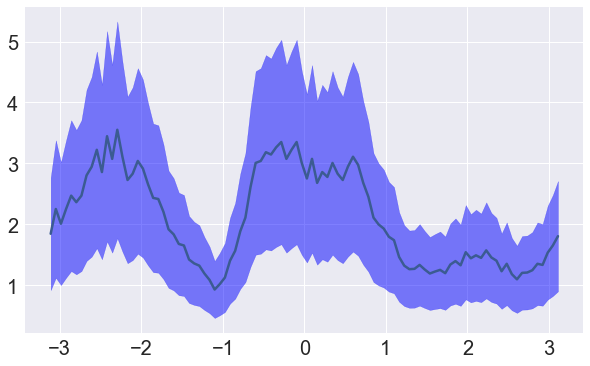

In [219]:
# from scipy import stats

# fig = plt.figure(figsize=(10,6))
# nrbins =100

# #free_energy_tmp, edges=np.histogram(cv, bins=nrbins, normed=True) # weights = weights,
# #free_energy= - np.log(free_energy_tmp)

# #bin_means, bin_edges, binnumber = stats.binned_statistic((np.linspace(-np.pi,  np.pi, num=len(cv))),cv, statistic='mean', bins=25)
# #bin_means, bin_edges, binnumber = stats.binned_statistic((np.linspace(-np.pi,  np.pi, num=len(cv))),cv, statistic='mean', bins=25)

# pi_marginal, bin_edges = np.histogram(cv, bins = nrbins,  density=True, normed=True)#weights = weights,

# bin_widths = bin_edges[1:] - bin_edges[:-1]
# bin_centers = bin_edges[:-1] + 0.5*bin_widths
# free_energy= - np.log(pi_marginal)


# err = -np.log(pi_marginal**0.5)
# cf_bottom =  free_energy + err #- np.log(pi_marginal+ err)
# cf_top = free_energy - err # - np.log(pi_marginal - err)

# plt.plot(bin_centers, free_energy, blue)
# plt.fill_between(bin_centers, cf_bottom, cf_top,
#                      color='b', alpha=.5)
# # plt.plot((np.linspace(-np.pi,  np.pi, num=len(cv))), cv, 'b.', label='raw data')
# # plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,label='binned statistic of data')
# plt.show()